In [69]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

fps 10 
frameCount 80 
frameWidth 160 
frameHeight 120


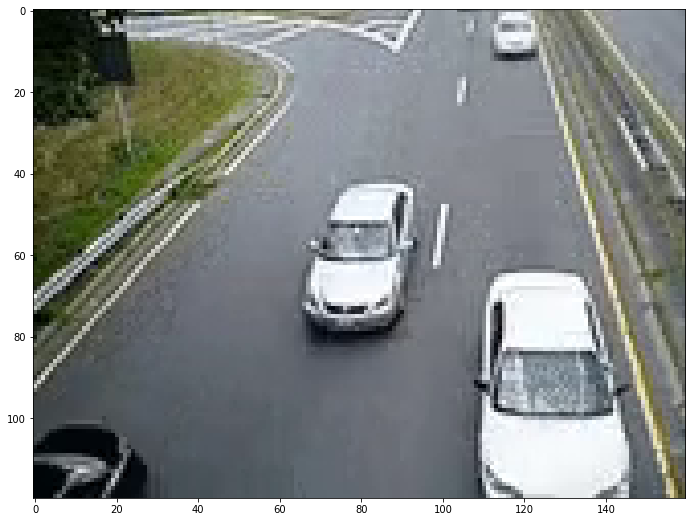

In [70]:


cap = cv2.VideoCapture("./assets/traffic.mp4")
fps = int(cap.get(cv2.CAP_PROP_FPS))
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0

while (fc < frameCount): # while (fc < frameCount  and ret):
  ret, buf[fc] = cap.read()
  fc += 1

print('fps', fps, '\nframeCount', frameCount, '\nframeWidth', frameWidth, '\nframeHeight', frameHeight)
plt.imshow(cv2.cvtColor(buf[50], cv2.COLOR_BGR2RGB))
plt.show()

In [71]:
stacked = np.stack(buf, axis=2)
stacked = stacked.reshape(frameHeight*frameWidth, frameCount, 3)
stacked.shape

(19200, 80, 3)

In [72]:
model = np.empty((frameHeight*frameWidth), dtype=GaussianMixture)

for i in range(frameHeight*frameWidth):
  model[i] = GaussianMixture(n_components=1,covariance_type='full', init_params='random').fit(stacked[i])

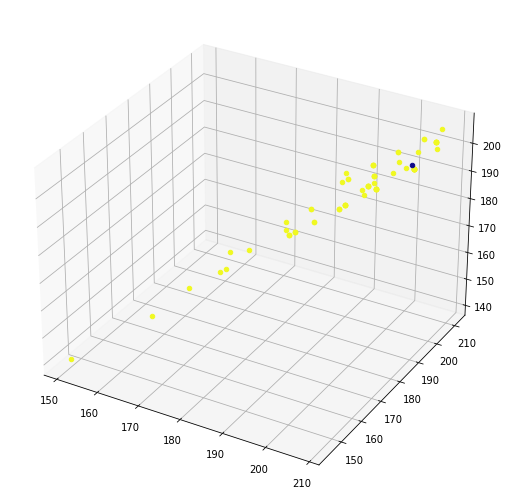

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scaler = MinMaxScaler(feature_range=(0,255))
# scaler = StandardScaler()
ii=1000

colors = plt.get_cmap('plasma')
scores = []
for point in stacked[ii]:
  score = [(model[ii].score_samples([point])[0])]
  scores.append(score)

scores = scaler.fit_transform(scores)
for score, point in zip(scores, stacked[ii]):
  color = colors(score)
  xs, ys, zs = point
  ax.scatter(xs, ys, zs, color=color)

In [74]:
background = np.empty((frameHeight*frameWidth, 3), np.dtype('uint8'))

for i in range(frameHeight*frameWidth):
    background[i] = np.array([*map(int, model[i].means_[0])])

background.shape

(19200, 3)

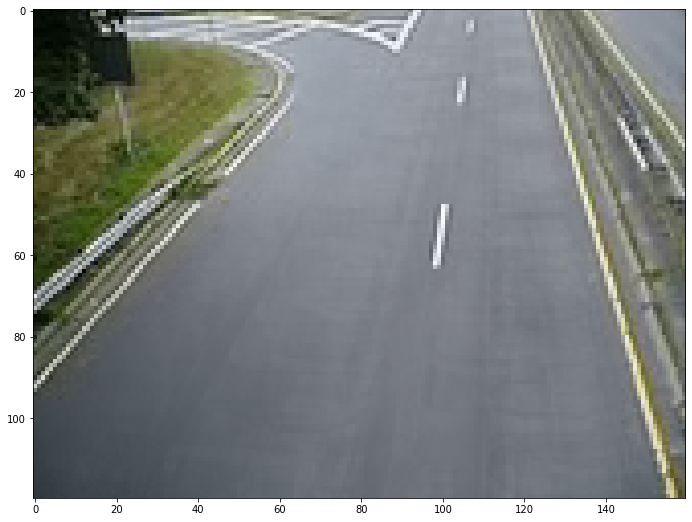

In [75]:
background = background.reshape(frameHeight, frameWidth, 3)
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

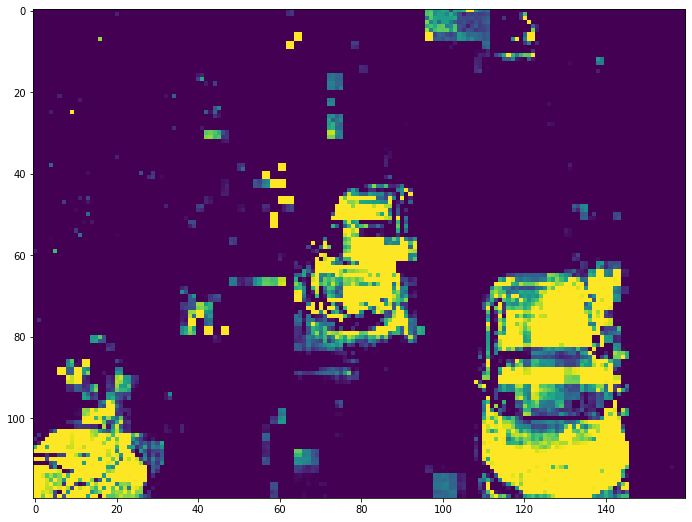

In [76]:
def squeeze(minimum, maximum, value):
  return min(maximum, max(minimum, value) - minimum)

movement = np.zeros((frameHeight*frameWidth, 1), np.dtype('uint8'))
frame = buf[50].reshape(frameHeight*frameWidth, 3)

for i in range(frameHeight*frameWidth):
  score = model[i].score_samples([frame[i]])[0]**2
  score = squeeze(100, 110, score)
  movement[i] = score

movement = movement.reshape(frameHeight, frameWidth)
plt.imshow(movement)
plt.show()

In [77]:
results = []
for i in range(frameCount):
  movement = np.zeros((frameHeight*frameWidth, 3), np.dtype('uint8'))
  frame = buf[i].reshape(frameHeight*frameWidth, 3)

  for j in range(frameHeight*frameWidth):
    score = model[j].score_samples([frame[j]])[0]**2
    score = squeeze(100, 150, score)
    movement[j] = score
  if i % 10 == 0:
    print(f'frame {i+1}/{frameCount}')
  results.append(movement.reshape(frameHeight, frameWidth, 3))

frame 1/80
frame 11/80
frame 21/80
frame 31/80
frame 41/80
frame 51/80
frame 61/80
frame 71/80


In [81]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('./assets/traffic_movement.mp4', fourcc, float(fps), (frameWidth, frameHeight))

for f in results:
  video.write(f)

video.release()  

In [83]:
from IPython.display import HTML
from base64 import b64encode
vid = open('./assets/traffic_movement.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(vid).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

[Link to output video](./assets/traffic_movement.mp4)

<video width="320" height="240" autoplay loop controls><source src="https://www.w3schools.com/html/mov_bbb.mp4" type="video/mp4"></video>

<video width="320" height="240" autoplay loop controls><source src="./assets/traffic_movement.mp4" type="video/mp4"></video>


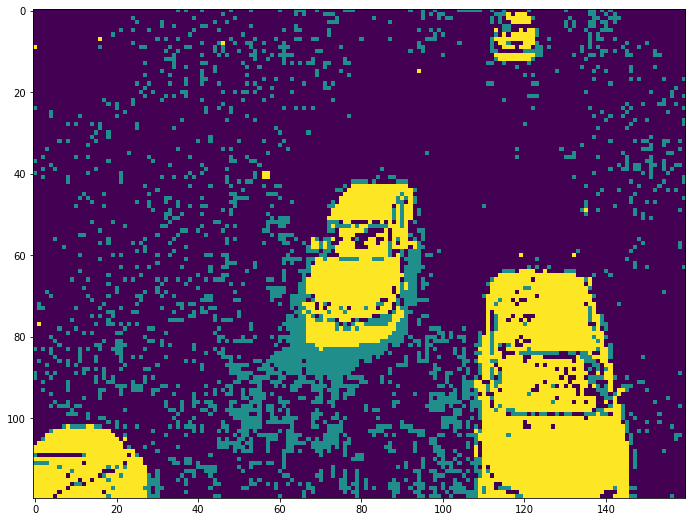

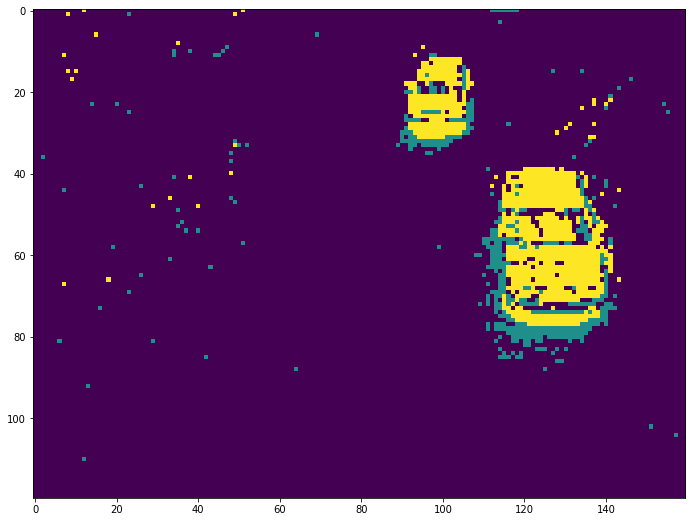

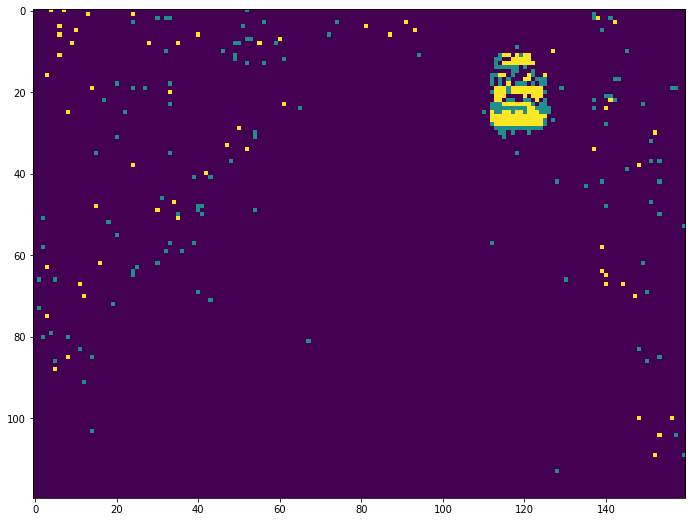

In [79]:
video2 = cv2.VideoWriter('./assets/traffic_movement_prod.mp4', fourcc, float(fps), (frameWidth, frameHeight))
backSub = cv2.createBackgroundSubtractorMOG2()
frames_to_plot = [50, 60, 70]

for i, frame in enumerate(buf):
  fgMask = backSub.apply(frame)
  video2.write(cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR))
  if i in frames_to_plot:
    plt.imshow(fgMask)
    plt.show()

video2.release()